In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Generation of synthetic data

In [2]:
df = pd.read_csv('signal.txt',header=None)
x = np.asarray(df)

Create T using the exponential sampling strategy : $$(\forall n \in\{1, \ldots, N\}) \quad T^{(n)}=T_{\min } \exp \left(-(n-1) \frac{\log \left(T_{\min } / T_{\max }\right)}{N-1}\right)$$
And create t using the regular sampling strategy : $$(\forall m \in\{1, \ldots, M\}) \quad t^{(m)}=t_{\min }+\frac{m-1}{M-1}\left(t_{\max }-t_{\min }\right)$$
Then, K is created using : $$(\forall m \in\{1, \ldots, M\})(\forall n \in\{1, \ldots, N\}) \quad K^{(m, n)}=\exp \left(-T^{(n)} t^{(m)}\right)$$

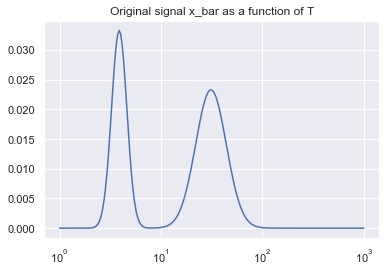

In [3]:
def exp_T(n, Tmin, Tmax, N):
    """
    Exponential sampling strategy
    """
    return Tmin * np.exp(- (n - 1) * np.log( Tmin / Tmax ) / (N - 1)) 

def reg_T(m, tmin, tmax, M):
    """
    Regular sampling strategy
    """
    return tmin + (tmax - tmin) * (m-1)/ (M - 1) 

N = 200
n = np.arange(N)+1
T_n_exp = exp_T(n, 1, 1000, N)

fg, ax  = plt.subplots(1,1)
ax.set_xscale('log')
ax.plot(T_n_exp, x)
ax.set_title('Original signal x_bar as a function of T')

M = 50
m = np.arange(M)+1
T_n_reg = reg_T(m, 0, 1.5, M)

K = np.exp(-T_n_reg.reshape(-1,1) @ T_n_exp.reshape(-1,1).T)

Text(0.5, 1.0, 'Resulting noisy data y as a function of t')

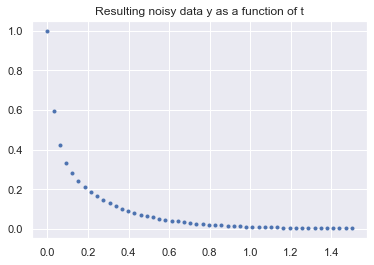

In [4]:
z = K @ x
sigma_2 = np.square(1e-2 * z[0]) * np.eye(M)
w = np.random.normal(loc = 0, scale=np.diag(sigma_2))
y = z.reshape(-1,) + w

fg, ax  = plt.subplots(1,1)
ax.plot(T_n_reg, y, linestyle='',marker='.')
ax.set_title('Resulting noisy data y as a function of t')

## Maximum Entropy Regularization

Find the solution $$\widehat{x}=\underset{x \in \mathbb{R}^{N}}{\operatorname{argmin}} \frac{1}{2}\|K x-y\|^{2}+\beta \operatorname{ent}(x)$$
Where, $$\left(\forall x \in \mathbb{R}^{N}\right) \quad \operatorname{ent}(x)=\sum_{n=1}^{N} \varphi\left(x^{(n)}\right)$$
With, $$(\forall u \in \mathbb{R}) \quad \varphi(u)=\left\{\begin{array}{ll}{u \log u} & {\text { if } u>0} \\ {0} & {\text { if } u=0} \\ {+\infty} & {\text { elsewhere }}\end{array}\right.$$

### Question 1 

$$
\frac{\partial^{2}(u \log u)}{\partial u^{2}} = \frac{\partial(\log u + u)}{\partial u} = \frac{1}{u}+1>0\\
\lim_{u \to 0^{+}} \varphi(u) = 0 = \varphi(0)
$$

Thus, $\varphi$ is convex on $\mathbb{R}^{*}_{+}$ and **ent is convex** on $(\mathbb{R}^{*}_{+})^{N}$ as a sum of convex functions.

ent is also **proper** as its domain is clearly not empty : $0_{\mathbb{R}^{N}} \in dom(ent)$.

ent is also lsc as a finite sum of lsc functions as $\varphi$ has a **closed epigraph**.

However, $\varphi$ is not differentiable at 0, and thus **ent is not differentiable on $\mathbb{R}^{N}$**.

### Question 2 

First, note that the norm doesn't have an impact on the needed properties of the global function to assess the existence and uniqueness of a solution. Indeed, it is convex, continuous, coercive and if ent is strictly convex, than the global function also is. Also note that $\mathbb{R}^{N}$ is **closed and convex**.

As we are working in a **finite dimension**, ent is lower-semicontinuous and coercive, then **ent is inf-compacte**. According to a theorem from the *optimization* course, we know that **the optimization problem has a solution**.

Moreover, as demonstrated in question 1, ent is **strictly convex** and thus **the optimization problem has a unique solution**.

### Question 3 

$$\forall x \in \mathbb{R}^{N}, \operatorname{prox}_{\gamma ent}(x) = (\operatorname{prox}_{\gamma \varphi}(x_{i}))_{i \in [1, N]}\\
\operatorname{prox}_{\gamma \varphi}(u)=\arg \min _{v \in \mathbb{R}} \frac{1}{2}(v-u)^{2}+\gamma v \log v \operatorname{, if} v \geq 0\\
\operatorname{Then, } h(v) = \frac{1}{2}(v-u)^{2}+\gamma v \log v\\
\frac{d h(v)}{d v}=v-u+\gamma (\log (v)+1)\\
\begin{aligned} 0=\frac{d h(v)}{d v} & \Leftrightarrow \frac{1}{\gamma} e^{\frac{u}{\gamma}}=\frac{v}{\gamma} e^{\frac{v}{\gamma}+1} \\ & \Leftrightarrow\frac{v}{\gamma} e^{\frac{v}{\gamma}}=e^{\frac{u}{\gamma}-1-\log \gamma} \end{aligned}$$
On introduit alors la fonction de Lambert 
$$W : \mathbb{C} \rightarrow \mathbb{C}\\ 
x \rightarrow f^{-1}(x)\\
\operatorname{With, } f(u)=u e^{u}$$
Hence, $$v=\gamma W\left(e^{\frac{u}{\gamma}-1-\log (\gamma)}\right)=\operatorname{prox}_{\gamma \varphi} u$$

Finally, 
$$\forall x \in \mathbb{R}^{N}, \operatorname{prox}_{\gamma ent}(x) = (\gamma W\left(e^{\frac{x_i}{\gamma}-1-\log (\gamma)}\right))_{i \in [1, N]}$$

Moreover, remember that $$\operatorname{prox}_{\frac{1}{2}\|K .-y\|^{2}}(x) = \left(K^{T} K+ \operatorname{id}\right)^{-1}\left(x+K^{T} y\right)$$

### Question 4 & 5
###### proximal operators

In [1]:
from  scipy.special import  lambertw

In [7]:
def prox_g(u, gamma=1):
    ''' 
    return the prox_{gamma * ent}(x)
    '''
#     print(lambertw(np.exp(u / gamma - 1 - np.log(gamma))))
    return(np.real(gamma * lambertw(np.exp(u / gamma - 1 - np.log(gamma)))))

def prox_f(x, K, y): 
    ''' 
    return the prox_{||K . -y ||^2}(x)
    '''
    return np.linalg.inv(K.T @ K + np.eye(K.shape[1])) @ (x + K.T @ y)

#### Forward Backward Algorithm

In [8]:
np.eye(K.shape[1]).shape
(K.T @ K).shape

(200, 200)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


Text(0.5, 1.0, 'Reconstruction result, Smoothness prior, beta=0, normalized_error=0')

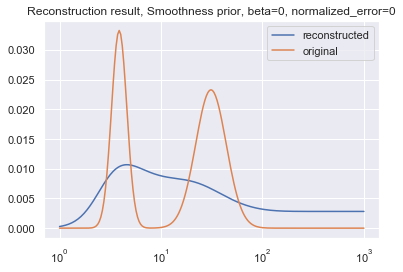

In [10]:
eps = 1e-6
converged = False 
beta = 1e-2
lambda_ = 1/2
nu = np.max(abs(np.linalg.eigvals(K.T @ K)))
gamma = 1/ nu 
x_n = np.zeros(x.shape)
while not converged : 
    y_n = x_n - gamma * K.T @ (K @ x_n - y.reshape(-1,1))

    x_n_ = x_n + lambda_ * (prox_g(y_n, gamma = gamma * beta) - x_n)
    if np.isinf(x_n_).any():
        raise ValueError
    err = np.linalg.norm(x_n_ - x_n, ord=2) / np.linalg.norm(x_n, ord=2)
    if err < eps : 
        converged = True
    x_n = x_n_
fg, ax = plt.subplots(1,1)
ax.set_xscale('log')
ax.plot(T_n_exp, x_n, label='reconstructed')
ax.plot(T_n_exp, x, label='original')
ax.legend()
ax.set_title('Reconstruction result, Smoothness prior, beta={0}, normalized_error={1}'.format(0, 0))

The use of the exp makes the implementation numerically instable which does not allow to reduce the beta parameter to smaller values.

#### Douglas-Rachford Algorithm 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'Reconstruction result, Smoothness prior, beta=0.001, normalized_error=0')

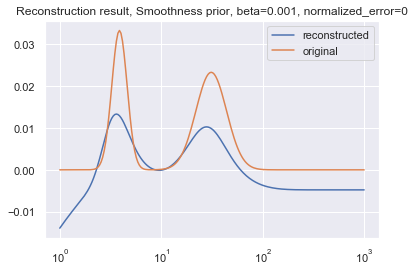

In [11]:
eps = 1e-6
converged = False 
beta = 0.000159
beta = 1e-3
lambda_ = 1/2
nu = np.max(abs(np.linalg.eigvals(K.T @ K)))
gamma = 2/ (1.001 * nu) 
gamma = 1
x_n = np.random.random(x.shape)
x_n = np.zeros(x.shape)
while not converged : 
    y_n = prox_g(x_n, gamma = beta)
    z_n = prox_f(2 * y_n - x_n, K, y.reshape(-1,1)) 
    x_n_ = x_n + lambda_ * (z_n - y_n)
    err = np.linalg.norm(x_n_ - x_n, ord=2) / np.linalg.norm(x_n, ord=2) 
    if err < eps : 
        converged = True
    x_n = x_n_ 
    
fg, ax = plt.subplots(1,1)
ax.set_xscale('log')
ax.plot(T_n_exp, x_n, label='reconstructed')
ax.plot(T_n_exp, x, label='original')
ax.legend()
ax.set_title('Reconstruction result, Smoothness prior, beta={0}, normalized_error={1}'.format(beta, 0))

### Question 6

Golden search for beta

### Question 7

Just comment visually the obtained curve with the ones from the previous TP.

### Question 8